## **Milestone Deliverable Two**

__In this implementation we create HER agent that is capable of performing functionalities for 3 RL different algorithms namely DDPG, TD3 and SAC.__

### **Setting up the working environment**

* __Downgrading tensorflow for `stable-baselines` support.__
* __Installing `highway-env` & `stable-baselines`.__
* __Setting up virtual display for google colab.__
* __Importing plotting and progress measurement packages.__



In [1]:
# Downgrading tensorflow version for compatability with stable-baselines package.
# stable-baselines hasn't been made compatible with Tensorflow-2.0.
# Hence, it can't be used directly with Tensorflow version installed in Colab.
! pip install tensorflow==1.15.3
# After this restart runtime and print the version output of tensorflow.

     |████████████████████████████████| 110.5MB 36kB/s 
     |████████████████████████████████| 512kB 58.7MB/s 
     |████████████████████████████████| 3.8MB 57.8MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=154d60b73e1ddc7f2095d8498f2b9fa32d5ddf9286cf3ecae7bbb17b163bc7f8
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully 

In [2]:
# Confirming that the package version has downgraded from Tensorflow-2.0.
import tensorflow as tf
print(tf.__version__)
# Output: 1.15.3

1.15.3


In [3]:
# Package download statements.
# Note 1: This time we also use ffmpeg package for handling video recording related tasks.
# Note 2: The package version are generic and doesn't require any specific package version downloads.
!pip install git+https://github.com/eleurent/highway-env
!apt-get update
!pip install pyvirtualdisplay
!apt-get install -y xvfb python-opengl ffmpeg

# Agent related import statements.
!pip install stable-baselines[mpi] --upgrade
# Restart runtime one more time for mpi4py package setup.

  Cloning https://github.com/eleurent/highway-env to /tmp/pip-req-build-nymdd949
  Running command git clone -q https://github.com/eleurent/highway-env /tmp/pip-req-build-nymdd949
     |████████████████████████████████| 11.5MB 4.2MB/s 
  Created wheel for highway-env: filename=highway_env-1.0.dev0-cp36-none-any.whl size=80898 sha256=7da789b3ab81b048460a28cbb3288de698e917ccb6f5ea7a083a5a19ac00c17d
  Stored in directory: /tmp/pip-ephem-wheel-cache-uxriwnrd/wheels/e6/10/d8/02a077ca221bbac1c6fc12c1370c2f773a8cd602d4be3df0cc
Successfully built highway-env
Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-lea

In [4]:
# Importing gym and highway_env for loading different parking environment scenarios.
import gym
import numpy as np
import highway_env

# Comparison between performance of three different algorithms with same parameters.
from stable_baselines import HER, SAC, DDPG, TD3
# tqdm: gives progress bars to loops.
from tqdm.notebook import trange

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [5]:
# Plotting the comparitive graph for different agents under analysis.
import matplotlib.pyplot as plt

In [20]:
# Similar, to earlier rendering procedures for creating virtual display.
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
from pathlib import Path
import base64

# Declaring display screen size for rendering highway-env environment.
display = Display(visible=0, size=(1366, 768))
display.start()

# These functions are also available in '/highway-env/scripts/' directory in utils.py
# file of highway-env github repository. These, can be directly accessed with below
# commands but we are using these functions here to fix a specific size of recorded videos.
# Note: commands are stated below for directly using these functions.
# Also, we have changed these functions slightly. Therefore, refer documentation.

# !git clone https://github.com/eleurent/highway-env.git
# import sys
# sys.path.insert(0, './highway-env/scripts/')
# from utils import record_videos, show_videos, capture_intermediate_frames

def wrap_env(env):
    '''
    Monitoring the environment interactions by agent and recording them in video.
    '''
    return Monitor(env, './video', force=True, video_callable=lambda episode: True)


def show_video():
    '''
    Reading the stored video and display the output inline with code cells.
    '''
    html = []
    for mp4 in Path('./video').glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 212px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))


def capture_intermediate_frames(env):
    '''
    Sending rendered frames to Monitor for logging video recording of captured frame.
    '''
    env.unwrapped.automatic_rendering_callback = env.video_recorder.capture_frame

## **Agent Structure Building and Training**

In [7]:
class HERAgent:
    """
    HER Agent class that wraps functionalities trained DDPG, TD3 and SAC RL models.
    """
    def __init__(self):
        """
        Variables required to initialize the HER constructor from stable-baselines package.
        ddpg_model, td3_model and sac_model variables stores the finally trained model.
        """
        self.sac_model = None    # Storing the trained model.
        self.ddpg_model = None    # Storing the trained model.
        self.td3_model = None    # Storing the trained model.
        self.sampled_goals = 4
        self.goal_strategy = 'future'
        self.verbose = 1
        self.buffer = int(1e6)
        self.alpha_lr = 1e-3
        self.discount_factor = 0.9
        self.batch = 256
        self.policy_args = dict(layers=[256, 256, 256])
        self.policy = 'MlpPolicy'

In [8]:
# Declaring instance of HER Agent class.
her_agent = HERAgent()

### **SAC Agent Training with HER Wrapper function**

In [9]:
env = gym.make("parking-v0")
# SAC parses the model class of Off-Policy RL model.
# 'MlpPolicy' implements actor-critic with a MLP (2 layers of 64 nodes).
her_agent.sac_model = HER(her_agent.policy, env, SAC, n_sampled_goal=her_agent.sampled_goals,
            goal_selection_strategy= her_agent.goal_strategy,
            verbose=her_agent.verbose, buffer_size=her_agent.buffer,
            learning_rate=her_agent.alpha_lr,
            gamma=her_agent.discount_factor, batch_size=her_agent.batch,
            policy_kwargs=her_agent.policy_args)
# argument: total_timesteps is passed as approximately 25k.
# It gives number of timestamps to train on.
her_agent.sac_model.learn(24768)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




------------------------------------------
| current_lr              | 0.001        |
| ent_coef                | 0.0032819018 |
| ent_coef_loss           | -0.8231822   |
| entropy                 | 1.0061102    |
| episodes                | 100          |
| fps                     | 23           |
| mean 100 episode reward | -43.8        |
| n_updates               | 9558         |
| policy_loss             | 2.1282835    |
| qf1_loss                | 0.004750901  |
| qf2_loss                | 0.0049080187 |
| success rate            | 0.05         |
| time_elapsed            | 410          |
| total timesteps         | 9657         |
| value_loss              | 0.009555617  |
-------------

In [10]:
env = gym.make("parking-v0")
# Creating reward_list for storing all the rewards.
sac_rewards = []
for episode in trange(100, desc="Calculating Average Reward Values"):
    obs, done = env.reset(), False
    rewards = 0.0
    while not done:
        action, _ = her_agent.sac_model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards = rewards + reward
    # Storing the reward function trend values.
    sac_rewards.append(rewards)
env.close()
# Storing the average value of rewards.
avg_sac_rewards = (sum(sac_rewards)/100)

print(sac_rewards)
print(avg_sac_rewards)


[-13.342062144028594, -21.16527260728508, -2.963415343751476, -12.311385008992469, -20.930278339631574, -17.592893128166644, -17.201570404165444, -22.510260068849924, -7.738823721401938, -4.553843297533467, -20.763635282255336, -32.86789472084054, -2.829874153035159, -7.29584180710374, -17.526100289828324, -17.698032432636136, -23.704685292672906, -8.054911817394421, -20.840679369161034, -16.507817835481063, -16.37104424475088, -13.527056508257502, -4.204513520279807, -16.662197137842174, -21.847454220085464, -17.484865627011693, -20.788157770504206, -15.408107874043337, -6.841449791671874, -15.34609601100144, -15.761441122052053, -23.65906261260574, -9.490838145940446, -15.81179359746361, -8.237069329859501, -9.705401367365635, -19.980442554509796, -14.716538063487237, -4.165274112028041, -15.547949178491464, -45.28218652706887, -9.900246308413, -10.873790232468664, -4.00671891784139, -11.521431025866436, -12.132151954006925, -15.37569274336281, -9.97398773059509, -15.2839235362714, 

### **DDPG Agent Training with HER Wrapper function**

In [11]:
env = gym.make("parking-v0")
# DDPG parses the model class of Off-Policy RL model.
# 'MlpPolicy' implements actor-critic with a MLP (2 layers of 64 nodes).
her_agent.ddpg_model = HER(her_agent.policy, env, DDPG, n_sampled_goal=her_agent.sampled_goals,
            goal_selection_strategy=her_agent.goal_strategy,
            verbose=her_agent.verbose, buffer_size=her_agent.buffer,
            gamma=her_agent.discount_factor, batch_size=her_agent.batch,
            policy_kwargs=her_agent.policy_args)
# argument: total_timesteps is passed as approximately 25k.
# It gives number of timestamps to train on.
her_agent.ddpg_model.learn(24768)



--------------------------------------
| reference_Q_mean        | -1.79    |
| reference_Q_std         | 1.38     |
| reference_action_mean   | 0.0852   |
| reference_action_std    | 0.818    |
| reference_actor_Q_mean  | -1.74    |
| reference_actor_Q_std   | 1.38     |
| rollout/Q_mean          | -1.42    |
| rollout/actions_mean    | 0.125    |
| rollout/actions_std     | 0.594    |
| rollout/episode_steps   | 97.7     |
| rollout/episodes        | 102      |
| rollout/return          | -71.1    |
| rollout/return_history  | -71.5    |
| success rate            | 0.03     |
| total/duration          | 278      |
| total/episodes          | 102      |
| total/epochs            | 1        |
| total/steps             | 9998     |
| total/steps_per_second  | 36       |
| train/loss_actor        | 1.74     |
| train/loss_critic       | 0.0224   |
| train/param_noise_di... | 0        |
--------------------------------------

--------------------------------------
| reference_Q_mean    

In [12]:
env = gym.make("parking-v0")
ddpg_rewards = []
for episode in trange(100, desc="Calculating Average Reward Values"):
    obs, done = env.reset(), False
    rewards = 0.0
    while not done:
        action, _ = her_agent.ddpg_model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards = rewards + reward
    # Storing the reward function trend values.
    ddpg_rewards.append(rewards)
env.close()
# Storing the average value of rewards. 
avg_ddpg_rewards = (sum(ddpg_rewards)/100)

print(ddpg_rewards)
print(avg_ddpg_rewards)


[-36.12306188787383, -41.178030948468326, -43.54865052019983, -30.286230063803927, -41.17524149156815, -47.21761280882746, -41.52275279244769, -31.16622579586246, -39.28248841210008, -37.02641469267506, -42.38747014741427, -36.00127357069038, -41.78043843755392, -43.93494160775431, -41.18113571945438, -42.60404547505497, -41.77180355075638, -40.66720293390521, -41.145573920461835, -33.52535441623505, -43.29487580537912, -42.23809734655902, -40.236297523480566, -30.378375320969297, -42.514473755783186, -34.526420153468436, -27.671899473119982, -37.97528911240688, -41.3487133227913, -30.832472158949212, -37.75351267372374, -38.303713091133844, -40.41385820415291, -30.149401394463805, -37.24678679562295, -40.08586871992365, -38.17177465145019, -45.471792679476884, -40.174089518874354, -42.926875551514776, -44.956807908602784, -36.39530892911121, -21.802685108456835, -9.747701312644336, -31.998833746368447, -30.883986938413226, -43.39136281474077, -40.01992231160977, -32.00799382296166, -

### **TD3 Agent Training with HER Wrapper function**

In [14]:
env = gym.make("parking-v0")
# DDPG parses the model class of Off-Policy RL model.
# 'MlpPolicy' implements actor-critic with a MLP (2 layers of 64 nodes).
her_agent.td3_model = HER(her_agent.policy, env, TD3, n_sampled_goal=her_agent.sampled_goals,
            goal_selection_strategy=her_agent.goal_strategy,
            verbose=her_agent.verbose, buffer_size=her_agent.buffer,
            gamma=her_agent.discount_factor, batch_size=her_agent.batch,
            policy_kwargs=her_agent.policy_args)
# argument: total_timesteps is passed as approximately 25k.
# It gives number of timestamps to train on.
her_agent.td3_model.learn(24768)

-----------------------------------------
| current_lr              | 0.0003      |
| episodes                | 100         |
| fps                     | 29          |
| mean 100 episode reward | -51.1       |
| n_updates               | 9700        |
| qf1_loss                | 0.05460834  |
| qf2_loss                | 0.052292436 |
| success rate            | 0.03        |
| time_elapsed            | 331         |
| total timesteps         | 9747        |
-----------------------------------------
-----------------------------------------
| current_lr              | 0.0003      |
| episodes                | 200         |
| fps                     | 29          |
| mean 100 episode reward | -44.7       |
| n_updates               | 19600       |
| qf1_loss                | 0.043851346 |
| qf2_loss                | 0.04401182  |
| success rate            | 0.02        |
| time_elapsed            | 666         |
| total timesteps         | 19610       |
----------------------------------

In [15]:
env = gym.make("parking-v0")
td3_rewards = []
for episode in trange(100, desc="Calculating Average Reward Values"):
    obs, done = env.reset(), False
    rewards = 0.0
    while not done:
        action, _ = her_agent.td3_model.predict(obs)
        obs, reward, done, info = env.step(action)
        rewards = rewards + reward
    # Storing the reward function trend values.
    td3_rewards.append(rewards)
env.close()
# Storing the average value of rewards.
avg_td3_rewards = (sum(td3_rewards)/100)

print(td3_rewards)
print(avg_td3_rewards)


[-26.956335350033925, -5.4729494770369405, -34.25669398439529, -39.44986830354726, -34.803553475375374, -30.80565809443616, -33.34462442450373, -32.03079882643512, -34.23068337041801, -32.40377721138946, -35.313867256213236, -35.582366680072894, -27.94107227451971, -50.58021684784715, -34.376320873625836, -26.868949553364097, -37.53588573314511, -48.001161127335145, -29.78776055122828, -47.27423628927126, -5.5595650959219, -35.17493771721682, -37.38267347285904, -41.072764071111514, -48.58200523815309, -47.67139979074719, -6.847318437657135, -43.29241939142294, -55.48999271677217, -33.56415066498324, -34.184967659525554, -32.02830002812699, -42.37724432742154, -47.34586110489932, -26.869607209979385, -6.677270145392914, -30.37018750178598, -34.49376118840769, -30.82452811440444, -31.728095431748994, -41.331458549491835, -39.66796597979386, -47.18384316476929, -39.322812002447506, -40.25310553038759, -27.6388410905694, -33.97713645964355, -31.8975104572217, -46.3575092661464, -31.96525

## **Plotting the reward values for all the agents trained**

In [16]:
 # Declaration of variables for graph creation.
 lower = 0
 upper = 100
 length = 100
 num_len = [lower + x*(upper-lower)/length for x in range(length)]
 print(num_len)

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0]


In [17]:
# Average plot line creation for graph population.
from itertools import repeat
avg_td3_rewards_list = []
avg_sac_rewards_list = []
avg_ddpg_rewards_list = []

avg_td3_rewards_list.extend(repeat(avg_td3_rewards, 100)) 
avg_ddpg_rewards_list.extend(repeat(avg_ddpg_rewards, 100)) 
avg_sac_rewards_list.extend(repeat(avg_sac_rewards, 100)) 

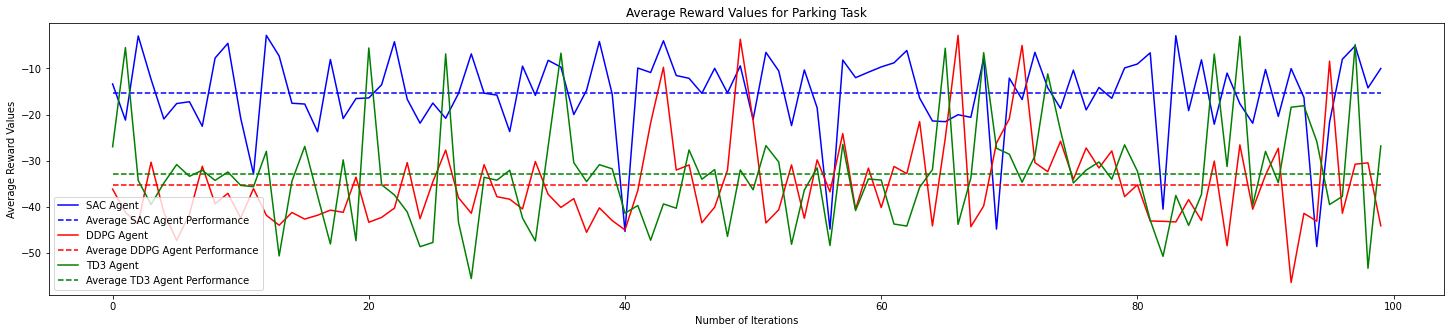

In [18]:
# Plotting the reward results after model training.
plt.figure(figsize=(25,5))

plt.plot(num_len, sac_rewards, label='SAC Agent', color="blue")
plt.plot(num_len, avg_sac_rewards_list, '--', label='Average SAC Agent Performance', color="blue")
plt.plot(num_len, ddpg_rewards, label='DDPG Agent', color="red")
plt.plot(num_len, avg_ddpg_rewards_list, '--', label='Average DDPG Agent Performance', color="red")
plt.plot(num_len, td3_rewards, label='TD3 Agent', color="green")
plt.plot(num_len, avg_td3_rewards_list, '--', label='Average TD3 Agent Performance', color="green")

plt.xlabel('Number of Iterations')
plt.ylabel('Average Reward Values')
plt.title('Average Reward Values for Parking Task')
plt.legend()

plt.show()

## **Displaying the video outputs of the problem and downloading them**

### **SAC agent interaction Output**

In [21]:
env = wrap_env(gym.make("parking-v0"))
# Running sample 10 episodes for video output.
for episode in trange(10, desc="Output Episodes for SAC Agent"):
    # capture_intermediate_frames is inside the loop
    # with this we can capture multiple iterations of goal completion
    # into our Monitor instance.
    obs, done = env.reset(), False
    capture_intermediate_frames

    while not done:
        action, _ = her_agent.sac_model.predict(obs)
        obs, reward, done, info = env.step(action)

env.close()

In [22]:
# Output the agent interactions with the environment.
show_video()

In [ ]:
# Zipping the video folder for the given SARSA agent.
!zip -r /content/file.zip /content/video
# Downloading the file resource.
from google.colab import files
files.download("/content/file.zip")
!rm -r video/

### **DDPG agent interaction Output**

In [23]:
env = wrap_env(gym.make("parking-v0"))
# Running sample 10 episodes for video output.
for episode in trange(10, desc="Output Episodes for DDPG Agent"):
    # capture_intermediate_frames is inside the loop
    # with this we can capture multiple iterations of goal completion
    # into our Monitor instance.
    obs, done = env.reset(), False
    capture_intermediate_frames

    while not done:
        action, _ = her_agent.ddpg_model.predict(obs)
        obs, reward, done, info = env.step(action)

env.close()

In [24]:
# Output the agent interactions with the environment.
show_video()

In [ ]:
# Zipping the video folder for the given SARSA agent.
!zip -r /content/file.zip /content/video
# Downloading the file resource.
from google.colab import files
files.download("/content/file.zip")
!rm -r video/

### **TD3 agent interaction Output**

In [25]:
env = wrap_env(gym.make("parking-v0"))
# Running sample 10 episodes for video output.
for episode in trange(10, desc="Output Episodes for TD3 Agent"):
    # capture_intermediate_frames is inside the loop
    # with this we can capture multiple iterations of goal completion
    # into our Monitor instance.
    obs, done = env.reset(), False
    capture_intermediate_frames

    while not done:
        action, _ = her_agent.td3_model.predict(obs)
        obs, reward, done, info = env.step(action)

env.close()

In [26]:
# Output the agent interactions with the environment.
show_video()

In [ ]:
# Zipping the video folder for the given SARSA agent.
!zip -r /content/file.zip /content/video
# Downloading the file resource.
from google.colab import files
files.download("/content/file.zip")
!rm -r video/